# Bayesian Demand Forecasting and Inventory Optimization for E-Commerce

## Project Overview

This notebook implements a complete Bayesian probabilistic forecasting system for e-commerce demand estimation and inventory optimization. We combine hierarchical Bayesian modeling, MCMC inference, and decision theory to quantify demand uncertainty and recommend optimal inventory levels.

### Key Objectives

1. Build a hierarchical Bayesian model for multi-category demand forecasting
2. Perform MCMC inference to estimate posterior distributions of demand parameters
3. Generate probabilistic forecasts with uncertainty quantification
4. Optimize inventory levels using decision theory under uncertainty
5. Conduct sensitivity analysis and provide actionable business recommendations

### Statistical Methods Applied

- **Bayesian Hierarchical Modeling**: Multi-level structure capturing category-specific and global demand patterns
- **MCMC Sampling**: Hamiltonian Monte Carlo via PyMC for posterior inference
- **Posterior Predictive Inference**: Generating future demand distributions
- **Uncertainty Quantification**: Credible intervals and predictive intervals
- **Decision Theory**: Optimal inventory decisions minimizing expected cost
- **Hypothesis Testing**: Bayesian comparison of demand across categories
- **Bootstrap Resampling**: Confidence intervals for key performance metrics

---

## 1. Environment Setup and Data Generation

### 1.1 Import Libraries

In [1]:
!pip install pymc arviz -q

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
import pymc as pm
import arviz as az
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Libraries imported successfully.')
print(f'PyMC version: {pm.__version__}')
print(f'ArviZ version: {az.__version__}')

Libraries imported successfully.
PyMC version: 5.25.1
ArviZ version: 0.22.0


### 1.2 Synthetic Data Generation

We generate realistic e-commerce demand data with the following characteristics:
- Multiple product categories with different demand patterns
- Trend component (linear growth)
- Seasonal component (weekly and monthly patterns)
- Category-specific baseline demand
- Observation noise

In [3]:
def generate_demand_data(n_days=365, n_categories=4, seed=42):
    """
    Generate synthetic e-commerce demand data.

    Parameters:
    -----------
    n_days : int
        Number of days to simulate
    n_categories : int
        Number of product categories
    seed : int
        Random seed for reproducibility

    Returns:
    --------
    df : pd.DataFrame
        Demand data with columns: day, category, demand
    true_params : dict
        True parameters used for data generation
    """
    np.random.seed(seed)

    # True parameters
    category_names = ['Electronics', 'Clothing', 'Home', 'Sports']
    baseline_demand = np.array([150, 200, 100, 80])  # Category-specific baseline
    trend_coef = np.array([0.15, 0.10, 0.08, 0.12])  # Linear trend per category
    seasonal_amplitude = np.array([40, 60, 30, 25])  # Seasonal variation
    noise_std = np.array([20, 25, 15, 12])  # Observation noise

    data = []
    for day in range(n_days):
        for cat_idx in range(n_categories):
            # Trend component
            trend = trend_coef[cat_idx] * day

            # Seasonal component (weekly + monthly)
            weekly_season = seasonal_amplitude[cat_idx] * np.sin(2 * np.pi * day / 7)
            monthly_season = seasonal_amplitude[cat_idx] * 0.5 * np.sin(2 * np.pi * day / 30)

            # Mean demand
            mu = baseline_demand[cat_idx] + trend + weekly_season + monthly_season

            # Observed demand (with noise, constrained to be positive)
            demand = np.maximum(np.random.normal(mu, noise_std[cat_idx]), 1)

            data.append({
                'day': day,
                'category': category_names[cat_idx],
                'category_id': cat_idx,
                'demand': demand
            })

    df = pd.DataFrame(data)
    true_params = {
        'baseline_demand': baseline_demand,
        'trend_coef': trend_coef,
        'seasonal_amplitude': seasonal_amplitude,
        'noise_std': noise_std
    }

    return df, true_params

# Generate data
df, true_params = generate_demand_data(n_days=365, n_categories=4)
print(f'Generated {len(df)} observations across {df["category"].nunique()} categories')
print(f'\nData shape: {df.shape}')
print(f'\nFirst few rows:')
print(df.head(10))
print(f'\nData summary:')
print(df.groupby('category')['demand'].describe())

Generated 1460 observations across 4 categories

Data shape: (1460, 4)

First few rows:
   day     category  category_id      demand
0    0  Electronics            0  159.934283
1    0     Clothing            1  196.543392
2    0         Home            2  109.715328
3    0       Sports            3   98.276358
4    1  Electronics            0  180.898426
5    1     Clothing            1  247.393816
6    1         Home            2  150.341812
7    1       Sports            3  111.473900
8    2  Electronics            0  188.042362
9    2     Clothing            1  284.461775

Data summary:
             count        mean        std        min         25%         50%  \
category                                                                       
Clothing     365.0  218.971983  54.240991  82.395783  178.203177  221.288618   
Electronics  365.0  178.163802  39.487103  82.622612  152.990840  176.928517   
Home         365.0  115.537498  29.410805  35.550150   94.208553  113.957910   
Sp

---

## 2. Exploratory Data Analysis

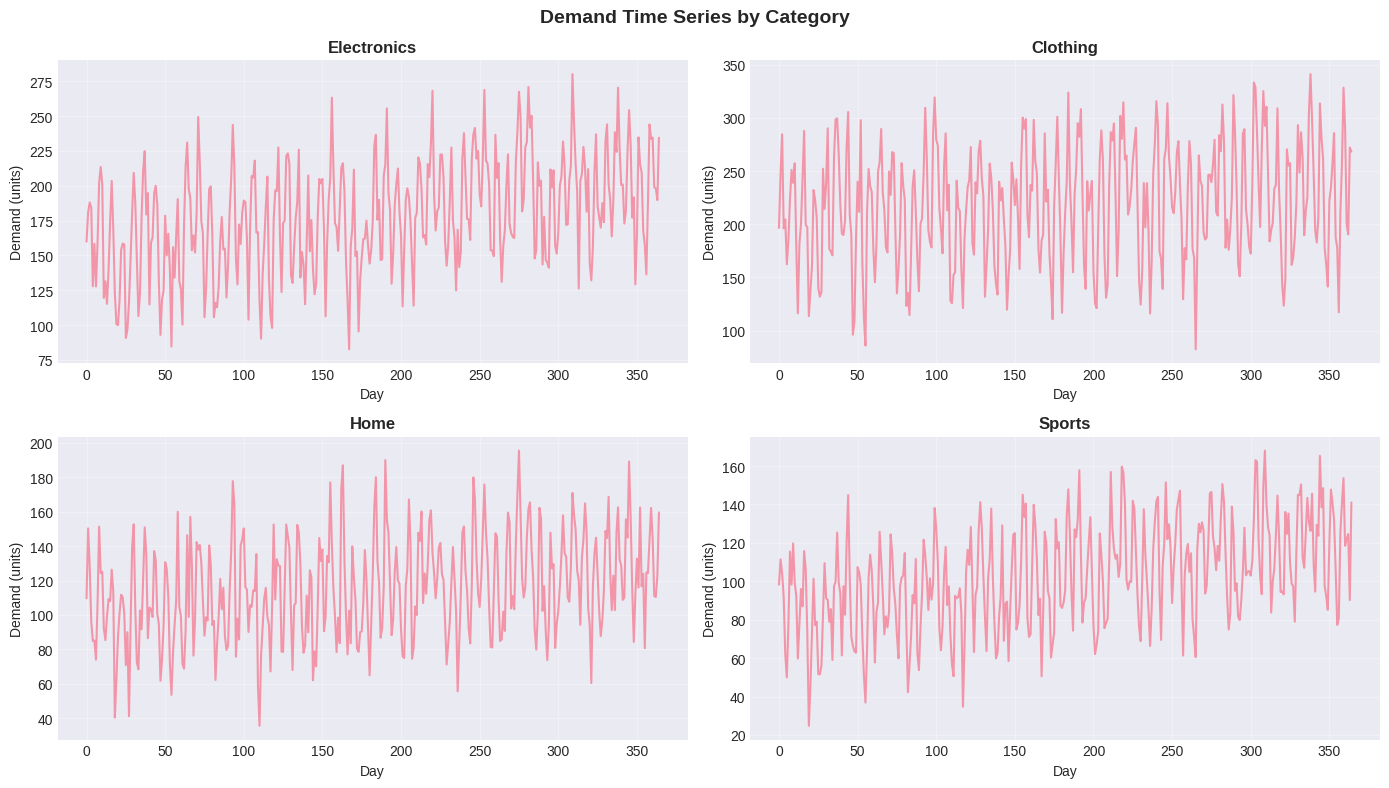

Time series visualization complete.


In [4]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Demand Time Series by Category', fontsize=14, fontweight='bold')

categories = df['category'].unique()
for idx, cat in enumerate(categories):
    ax = axes[idx // 2, idx % 2]
    cat_data = df[df['category'] == cat]
    ax.plot(cat_data['day'], cat_data['demand'], linewidth=1.5, alpha=0.7)
    ax.set_title(f'{cat}', fontweight='bold')
    ax.set_xlabel('Day')
    ax.set_ylabel('Demand (units)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('Time series visualization complete.')

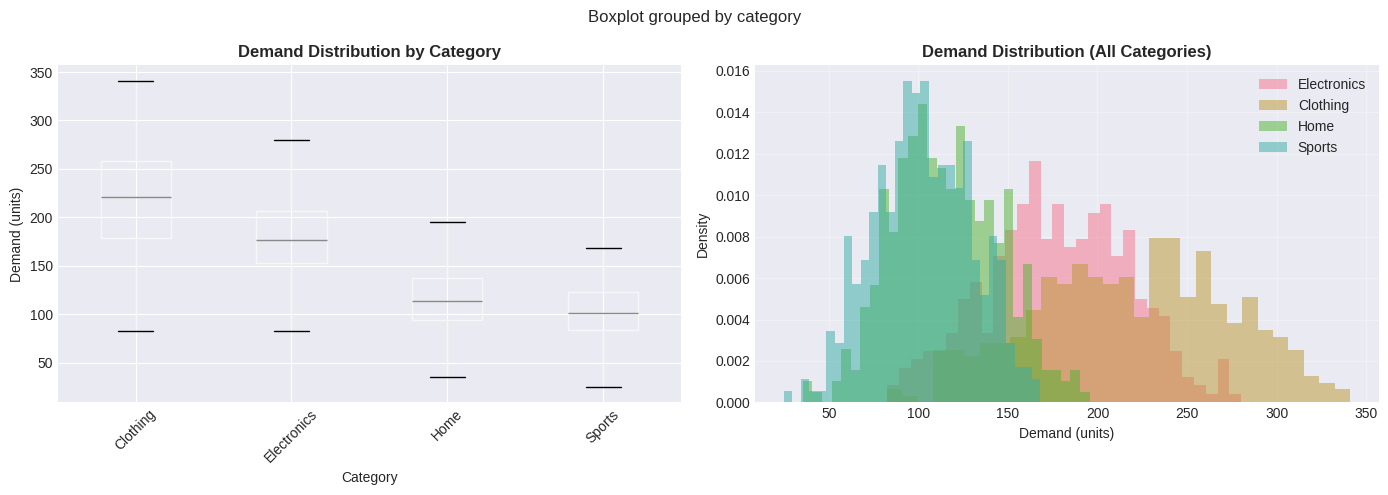

Distribution analysis complete.


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution by category
ax = axes[0]
df.boxplot(column='demand', by='category', ax=ax)
ax.set_title('Demand Distribution by Category', fontweight='bold')
ax.set_xlabel('Category')
ax.set_ylabel('Demand (units)')
plt.sca(ax)
plt.xticks(rotation=45)

# Histogram with KDE
ax = axes[1]
for cat in categories:
    cat_data = df[df['category'] == cat]['demand']
    ax.hist(cat_data, bins=30, alpha=0.5, label=cat, density=True)
ax.set_xlabel('Demand (units)')
ax.set_ylabel('Density')
ax.set_title('Demand Distribution (All Categories)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('Distribution analysis complete.')

---

## 3. Bayesian Hierarchical Model Specification

### 3.1 Model Description

We specify a hierarchical Bayesian model that captures both category-specific and global demand patterns:

**Likelihood:**
$$D_{i,t} \sim \text{Normal}(\mu_{i,t}, \sigma_i^2)$$

where $D_{i,t}$ is demand for category $i$ on day $t$.

**Mean Structure:**
$$\mu_{i,t} = \alpha_i + \beta_i \cdot t + \gamma_i \cdot \sin(2\pi t / 7) + \delta_i \cdot \sin(2\pi t / 30)$$

**Priors (Hierarchical):**
- $\alpha_i \sim \text{Normal}(\mu_\alpha, \sigma_\alpha^2)$ (category baseline)
- $\beta_i \sim \text{Normal}(\mu_\beta, \sigma_\beta^2)$ (category trend)
- $\gamma_i \sim \text{Normal}(\mu_\gamma, \sigma_\gamma^2)$ (weekly seasonality)
- $\delta_i \sim \text{Normal}(\mu_\delta, \sigma_\delta^2)$ (monthly seasonality)
- $\sigma_i \sim \text{HalfNormal}(\sigma_\sigma)$ (observation noise)

**Hyperpriors:**
- $\mu_\alpha \sim \text{Normal}(150, 50^2)$
- $\mu_\beta \sim \text{Normal}(0.1, 0.1^2)$
- $\mu_\gamma, \mu_\delta \sim \text{Normal}(0, 30^2)$
- $\sigma_\alpha, \sigma_\beta, \sigma_\gamma, \sigma_\delta, \sigma_\sigma \sim \text{HalfNormal}(50)$

In [6]:
# Prepare data for modeling
n_categories = df['category'].nunique()
n_obs = len(df)

# Create design matrix for seasonal components
days = df['day'].values
weekly_sin = np.sin(2 * np.pi * days / 7)
monthly_sin = np.sin(2 * np.pi * days / 30)
category_ids = df['category_id'].values
demand = df['demand'].values

print(f'Data prepared for modeling:')
print(f'  Number of observations: {n_obs}')
print(f'  Number of categories: {n_categories}')
print(f'  Days range: {days.min()} to {days.max()}')

Data prepared for modeling:
  Number of observations: 1460
  Number of categories: 4
  Days range: 0 to 364


In [7]:
# Build Bayesian hierarchical model
with pm.Model() as model:
    # Hyperpriors for global parameters
    mu_alpha = pm.Normal('mu_alpha', mu=150, sigma=50)
    sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=50)

    mu_beta = pm.Normal('mu_beta', mu=0.1, sigma=0.1)
    sigma_beta = pm.HalfNormal('sigma_beta', sigma=0.1)

    mu_gamma = pm.Normal('mu_gamma', mu=0, sigma=30)
    sigma_gamma = pm.HalfNormal('sigma_gamma', sigma=30)

    mu_delta = pm.Normal('mu_delta', mu=0, sigma=30)
    sigma_delta = pm.HalfNormal('sigma_delta', sigma=30)

    sigma_sigma = pm.HalfNormal('sigma_sigma', sigma=50)

    # Category-specific parameters (hierarchical)
    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha, shape=n_categories)
    beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=n_categories)
    gamma = pm.Normal('gamma', mu=mu_gamma, sigma=sigma_gamma, shape=n_categories)
    delta = pm.Normal('delta', mu=mu_delta, sigma=sigma_delta, shape=n_categories)
    sigma = pm.HalfNormal('sigma', sigma=sigma_sigma, shape=n_categories)

    # Linear predictor
    mu = (alpha[category_ids] +
          beta[category_ids] * days +
          gamma[category_ids] * weekly_sin +
          delta[category_ids] * monthly_sin)

    # Likelihood
    y = pm.Normal('y', mu=mu, sigma=sigma[category_ids], observed=demand)

    print('Model specification complete.')
    print(model)

Model specification complete.


### 3.2 MCMC Inference

We use Hamiltonian Monte Carlo (HMC) via PyMC to sample from the posterior distribution. This will take a few minutes.

In [8]:
# Perform MCMC sampling
with model:
    trace = pm.sample(
        draws=2000,
        tune=1000,
        chains=2,
        cores=2,
        target_accept=0.9,
        random_seed=42,
        progressbar=True,
        return_inferencedata=True
    )

print('\nMCMC sampling complete.')

Output()


MCMC sampling complete.


### 3.3 Posterior Diagnostics

We examine convergence diagnostics to ensure the MCMC chains have converged properly.

In [9]:
# Summary statistics
summary = az.summary(trace, var_names=['mu_alpha', 'mu_beta', 'mu_gamma', 'mu_delta', 'sigma_sigma'])
print('Posterior Summary (Hyperparameters):')
print(summary)
print(f'\nAll Rhat values < 1.01: {(summary["r_hat"] < 1.01).all()}')

Posterior Summary (Hyperparameters):
                mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_alpha     135.931  24.731  90.610  182.409      0.320    0.497    6094.0   
mu_beta        0.119   0.024   0.073    0.165      0.000    0.001    3647.0   
mu_gamma      34.815  10.318  13.695   53.035      0.187    0.248    3658.0   
mu_delta      18.366   6.619   5.289   31.167      0.131    0.205    3000.0   
sigma_sigma   25.462  11.470   9.773   45.863      0.181    0.288    7128.0   

             ess_tail  r_hat  
mu_alpha       2560.0    1.0  
mu_beta        2197.0    1.0  
mu_gamma       2179.0    1.0  
mu_delta       2093.0    1.0  
sigma_sigma    2651.0    1.0  

All Rhat values < 1.01: True


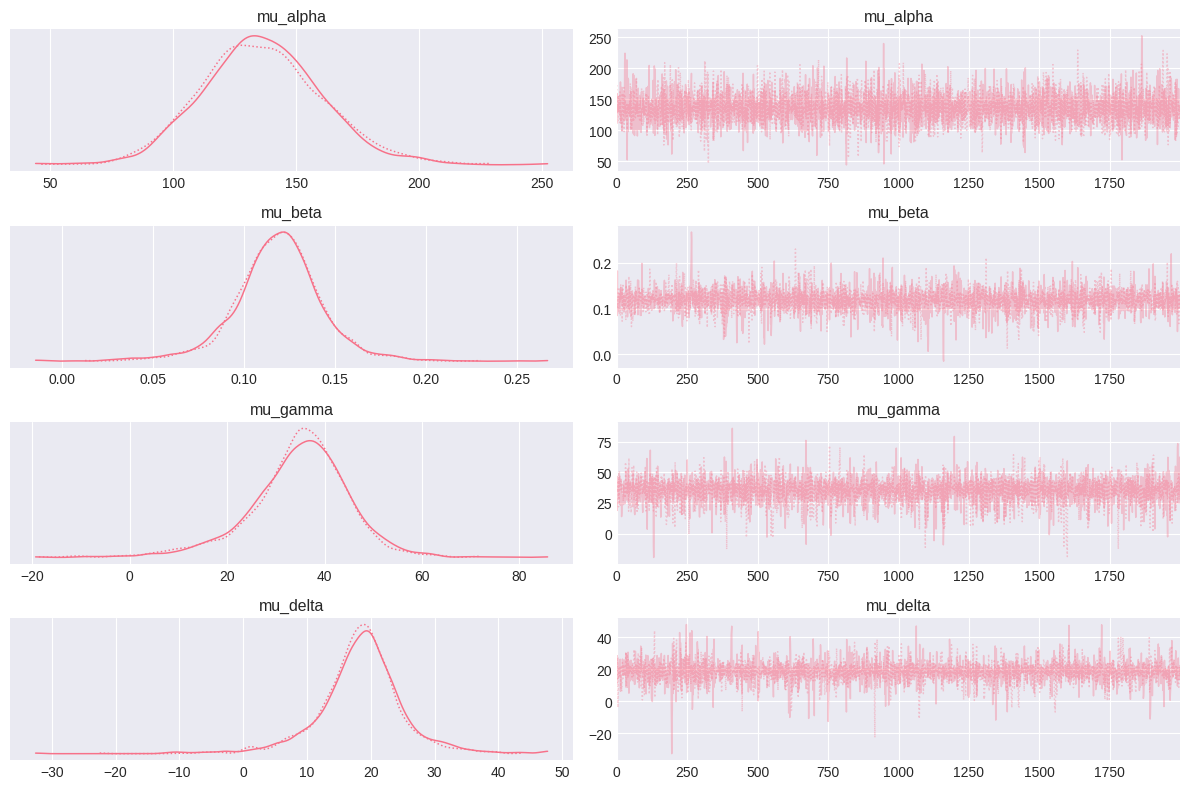

Trace plots generated.


In [10]:
# Trace plots for hyperparameters
az.plot_trace(
    trace,
    var_names=['mu_alpha', 'mu_beta', 'mu_gamma', 'mu_delta'],
    figsize=(12, 8)
)
plt.tight_layout()
plt.show()

print('Trace plots generated.')

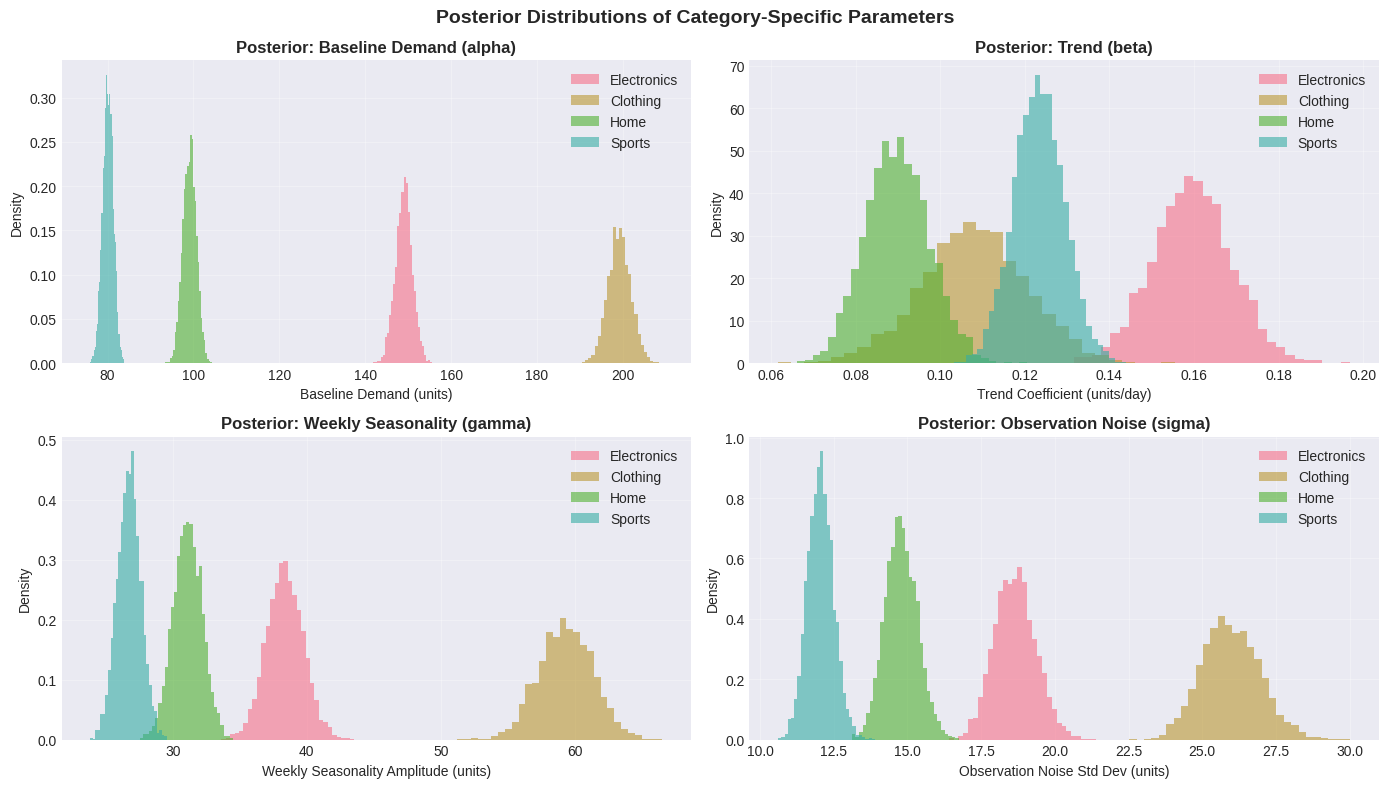

Posterior distributions visualized.


In [11]:
# Posterior distributions of category-specific parameters
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Posterior Distributions of Category-Specific Parameters', fontsize=14, fontweight='bold')

category_names = ['Electronics', 'Clothing', 'Home', 'Sports']

# Baseline demand (alpha)
ax = axes[0, 0]
alpha_samples = trace.posterior['alpha'].values.reshape(-1, n_categories)
for i in range(n_categories):
    ax.hist(alpha_samples[:, i], bins=30, alpha=0.6, label=category_names[i], density=True)
ax.set_xlabel('Baseline Demand (units)')
ax.set_ylabel('Density')
ax.set_title('Posterior: Baseline Demand (alpha)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Trend (beta)
ax = axes[0, 1]
beta_samples = trace.posterior['beta'].values.reshape(-1, n_categories)
for i in range(n_categories):
    ax.hist(beta_samples[:, i], bins=30, alpha=0.6, label=category_names[i], density=True)
ax.set_xlabel('Trend Coefficient (units/day)')
ax.set_ylabel('Density')
ax.set_title('Posterior: Trend (beta)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Weekly seasonality (gamma)
ax = axes[1, 0]
gamma_samples = trace.posterior['gamma'].values.reshape(-1, n_categories)
for i in range(n_categories):
    ax.hist(gamma_samples[:, i], bins=30, alpha=0.6, label=category_names[i], density=True)
ax.set_xlabel('Weekly Seasonality Amplitude (units)')
ax.set_ylabel('Density')
ax.set_title('Posterior: Weekly Seasonality (gamma)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Observation noise (sigma)
ax = axes[1, 1]
sigma_samples = trace.posterior['sigma'].values.reshape(-1, n_categories)
for i in range(n_categories):
    ax.hist(sigma_samples[:, i], bins=30, alpha=0.6, label=category_names[i], density=True)
ax.set_xlabel('Observation Noise Std Dev (units)')
ax.set_ylabel('Density')
ax.set_title('Posterior: Observation Noise (sigma)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('Posterior distributions visualized.')

---

## 4. Posterior Predictive Analysis and Forecasting

### 4.1 Generate Posterior Predictive Samples

We generate predictions for future demand with full uncertainty quantification.

In [12]:
# Generate posterior predictive samples for future days
n_forecast_days = 60
forecast_days = np.arange(365, 365 + n_forecast_days)

# Design matrix for forecast period
forecast_weekly_sin = np.sin(2 * np.pi * forecast_days / 7)
forecast_monthly_sin = np.sin(2 * np.pi * forecast_days / 30)

# Extract posterior samples
alpha_samples = trace.posterior['alpha'].values.reshape(-1, n_categories)
beta_samples = trace.posterior['beta'].values.reshape(-1, n_categories)
gamma_samples = trace.posterior['gamma'].values.reshape(-1, n_categories)
delta_samples = trace.posterior['delta'].values.reshape(-1, n_categories)
sigma_samples = trace.posterior['sigma'].values.reshape(-1, n_categories)

n_posterior_samples = alpha_samples.shape[0]

# Generate posterior predictive samples
posterior_predictive_samples = np.zeros((n_posterior_samples, n_forecast_days, n_categories))

for s in range(n_posterior_samples):
    for cat in range(n_categories):
        mu_forecast = (alpha_samples[s, cat] +
                      beta_samples[s, cat] * forecast_days +
                      gamma_samples[s, cat] * forecast_weekly_sin +
                      delta_samples[s, cat] * forecast_monthly_sin)
        posterior_predictive_samples[s, :, cat] = np.random.normal(
            mu_forecast, sigma_samples[s, cat]
        )

print(f'Generated {n_posterior_samples} posterior predictive samples')
print(f'Forecast horizon: {n_forecast_days} days')
print(f'Posterior predictive samples shape: {posterior_predictive_samples.shape}')

Generated 4000 posterior predictive samples
Forecast horizon: 60 days
Posterior predictive samples shape: (4000, 60, 4)


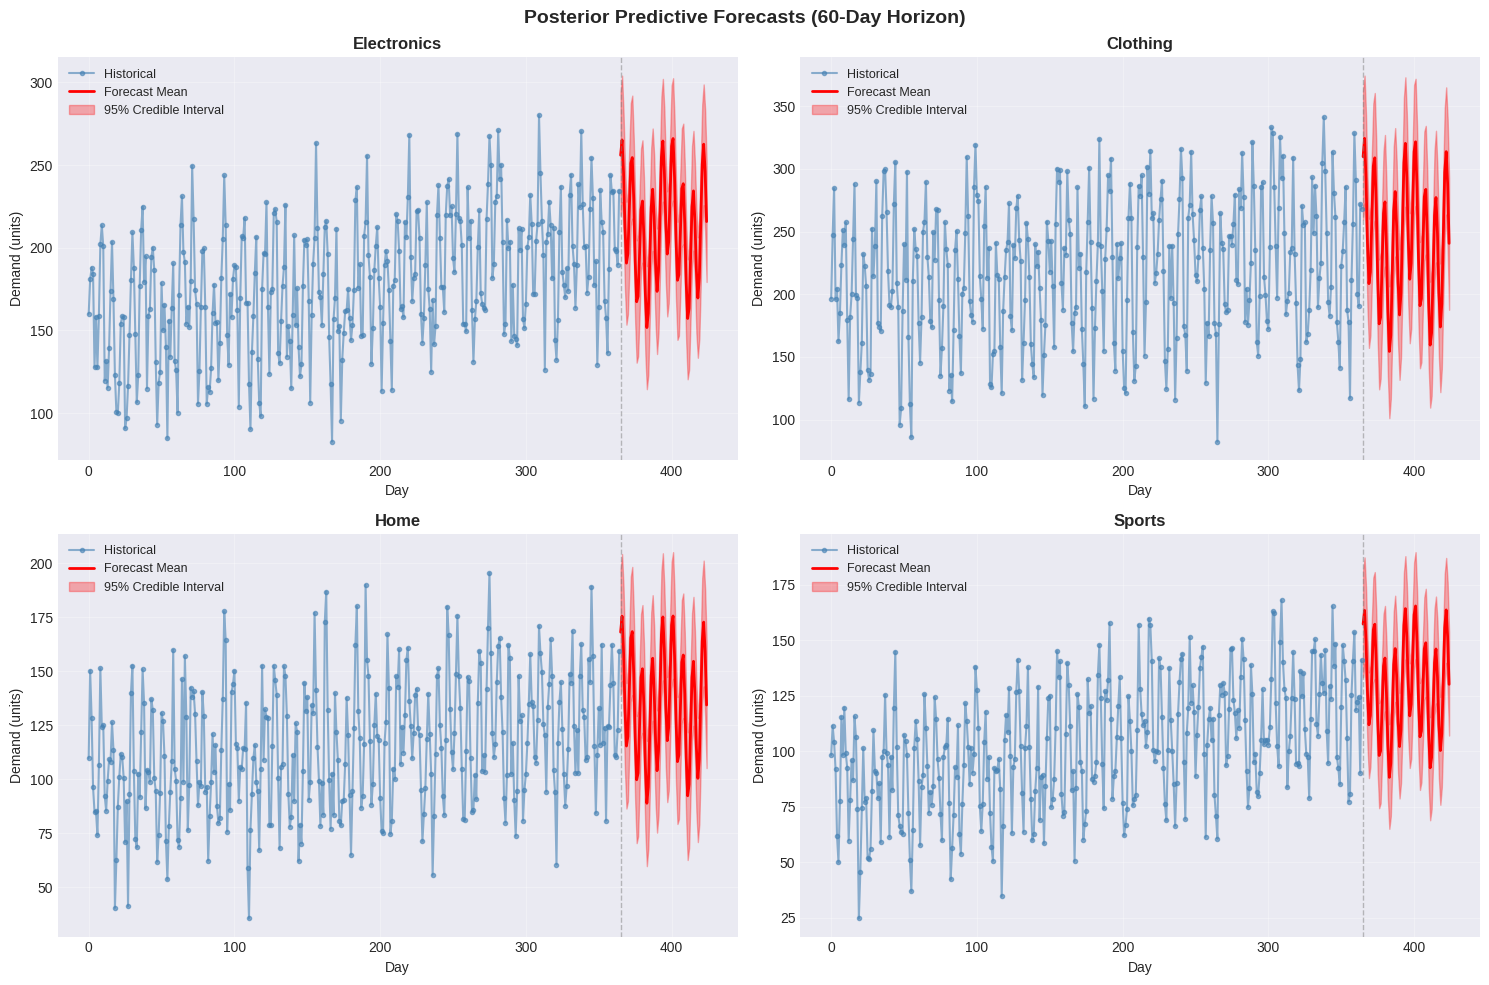

Forecast visualization complete.


In [13]:
# Compute forecast statistics (mean, credible intervals)
forecast_mean = posterior_predictive_samples.mean(axis=0)
forecast_lower = np.percentile(posterior_predictive_samples, 2.5, axis=0)
forecast_upper = np.percentile(posterior_predictive_samples, 97.5, axis=0)

# Visualization: Forecast with uncertainty bands
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Posterior Predictive Forecasts (60-Day Horizon)', fontsize=14, fontweight='bold')

for cat_idx, cat_name in enumerate(category_names):
    ax = axes[cat_idx // 2, cat_idx % 2]

    # Historical data
    hist_data = df[df['category'] == cat_name]
    ax.plot(hist_data['day'], hist_data['demand'], 'o-', linewidth=1.5,
            markersize=3, alpha=0.6, label='Historical', color='steelblue')

    # Forecast mean
    ax.plot(forecast_days, forecast_mean[:, cat_idx], 'r-', linewidth=2, label='Forecast Mean')

    # Credible interval (95%)
    ax.fill_between(forecast_days, forecast_lower[:, cat_idx], forecast_upper[:, cat_idx],
                     alpha=0.3, color='red', label='95% Credible Interval')

    ax.axvline(x=365, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    ax.set_xlabel('Day')
    ax.set_ylabel('Demand (units)')
    ax.set_title(f'{cat_name}', fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('Forecast visualization complete.')

In [14]:
# Forecast summary statistics
forecast_summary = pd.DataFrame()

for cat_idx, cat_name in enumerate(category_names):
    forecast_summary = pd.concat([
        forecast_summary,
        pd.DataFrame({
            'Category': cat_name,
            'Mean Demand': [forecast_mean[:, cat_idx].mean()],
            'Std Dev': [forecast_mean[:, cat_idx].std()],
            'Lower 95%': [forecast_lower[:, cat_idx].mean()],
            'Upper 95%': [forecast_upper[:, cat_idx].mean()],
            'Forecast Uncertainty': [forecast_upper[:, cat_idx].mean() - forecast_lower[:, cat_idx].mean()]
        })
    ], ignore_index=True)

print('\nForecast Summary Statistics (60-Day Horizon):')
print(forecast_summary.to_string(index=False))


Forecast Summary Statistics (60-Day Horizon):
   Category  Mean Demand   Std Dev  Lower 95%  Upper 95%  Forecast Uncertainty
Electronics   213.052772 31.339682 176.218997 249.817537             73.598540
   Clothing   243.470987 47.041188 192.134971 294.910631            102.775660
       Home   135.416060 24.357485 106.132058 164.689493             58.557434
     Sports   129.519301 21.202934 105.530336 153.415422             47.885085


---

## 5. Inventory Optimization via Decision Theory

### 5.1 Cost Model and Optimal Inventory Decision

We formulate an inventory optimization problem under uncertainty:

**Cost Function:**
$$C(Q) = h \cdot E[\max(Q - D, 0)] + p \cdot E[\max(D - Q, 0)]$$

where:
- $Q$ = inventory quantity (decision variable)
- $D$ = random demand
- $h$ = holding cost per unit (inventory cost)
- $p$ = penalty cost per unit (stockout cost)

The optimal inventory level minimizes expected cost.

In [15]:
def compute_inventory_cost(Q, demand_samples, h=1.0, p=5.0):
    """
    Compute expected inventory cost for a given order quantity Q.

    Parameters:
    -----------
    Q : float
        Order quantity (inventory level)
    demand_samples : array
        Samples from posterior predictive demand distribution
    h : float
        Holding cost per unit
    p : float
        Penalty cost per unit (stockout cost)

    Returns:
    --------
    cost : float
        Expected total cost
    """
    overstock = np.maximum(Q - demand_samples, 0)
    understock = np.maximum(demand_samples - Q, 0)
    cost = h * overstock.mean() + p * understock.mean()
    return cost

# Optimize inventory for each category
inventory_results = {}

for cat_idx, cat_name in enumerate(category_names):
    # Aggregate demand samples across forecast period
    demand_samples = posterior_predictive_samples[:, :, cat_idx].flatten()

    # Optimize
    result = minimize(
        lambda Q: compute_inventory_cost(Q, demand_samples, h=1.0, p=5.0),
        x0=forecast_mean[:, cat_idx].mean(),
        bounds=[(0, 500)],
        method='L-BFGS-B'
    )

    optimal_Q = result.x[0]
    optimal_cost = result.fun

    inventory_results[cat_name] = {
        'optimal_Q': optimal_Q,
        'optimal_cost': optimal_cost,
        'demand_mean': demand_samples.mean(),
        'demand_std': demand_samples.std(),
        'demand_samples': demand_samples
    }

# Display results
inventory_df = pd.DataFrame([
    {
        'Category': cat,
        'Optimal Inventory (Q*)': results['optimal_Q'],
        'Expected Cost': results['optimal_cost'],
        'Mean Demand': results['demand_mean'],
        'Demand Std Dev': results['demand_std'],
        'Safety Stock': results['optimal_Q'] - results['demand_mean']
    }
    for cat, results in inventory_results.items()
])

print('\nOptimal Inventory Levels (Minimizing Expected Cost):')
print(inventory_df.to_string(index=False))


Optimal Inventory Levels (Minimizing Expected Cost):
   Category  Optimal Inventory (Q*)  Expected Cost  Mean Demand  Demand Std Dev  Safety Stock
Electronics              250.751073      54.026782   213.052772       36.555950     37.698301
   Clothing              299.660060      79.169596   243.470987       53.846840     56.189073
       Home              165.009267      42.022831   135.416060       28.593519     29.593206
     Sports              154.962696      35.961943   129.519301       24.459424     25.443394


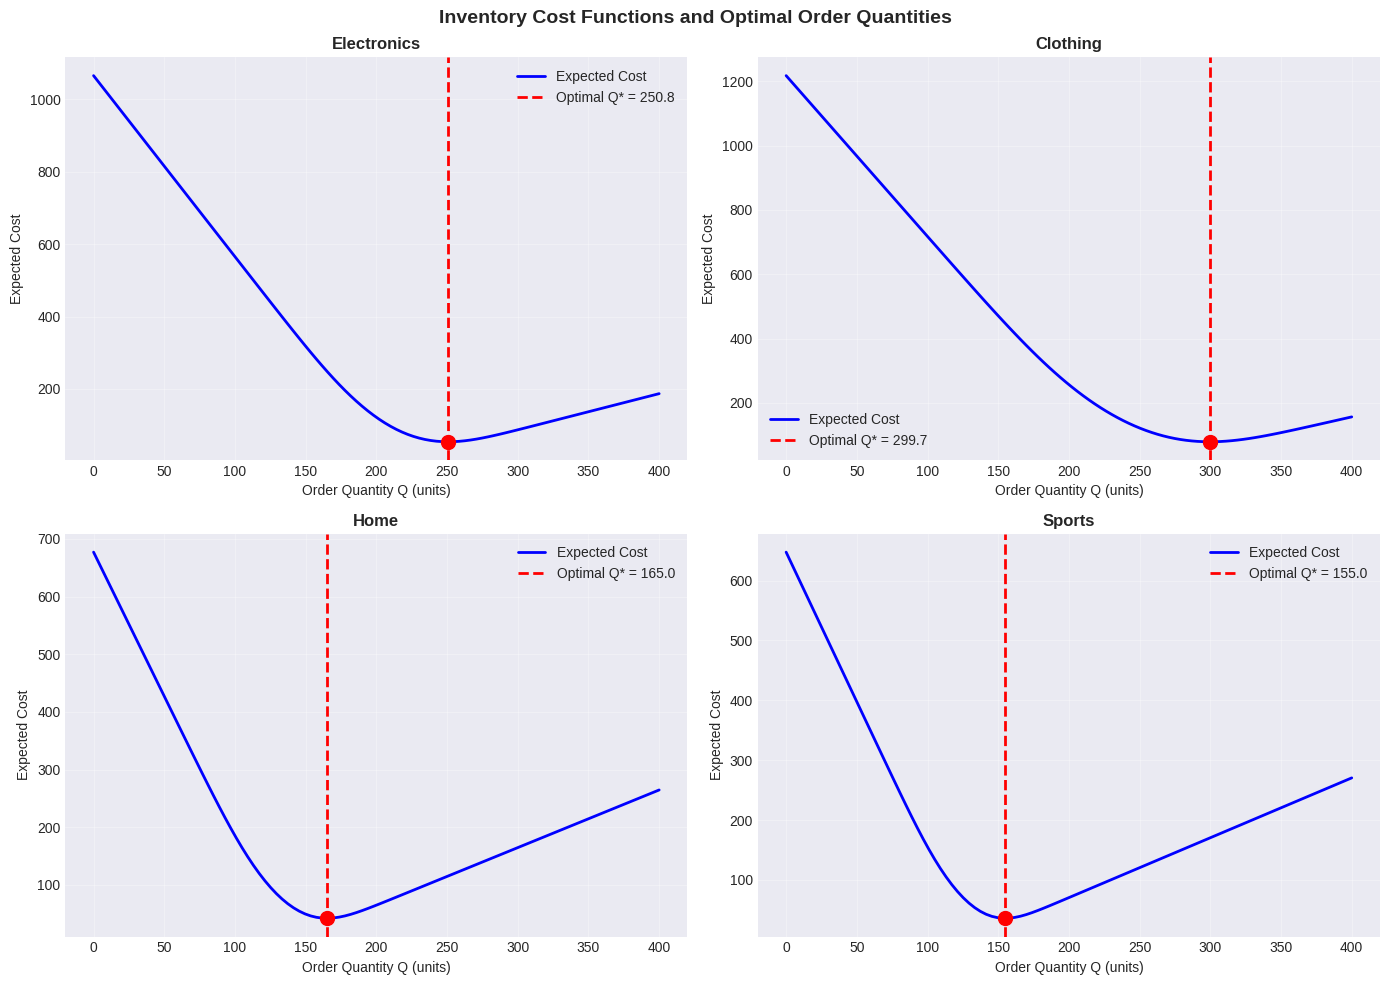

Cost function visualization complete.


In [16]:
# Visualize cost functions and optimal points
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Inventory Cost Functions and Optimal Order Quantities', fontsize=14, fontweight='bold')

for cat_idx, cat_name in enumerate(category_names):
    ax = axes[cat_idx // 2, cat_idx % 2]

    demand_samples = inventory_results[cat_name]['demand_samples']
    Q_range = np.linspace(0, 400, 100)
    costs = [compute_inventory_cost(Q, demand_samples, h=1.0, p=5.0) for Q in Q_range]

    ax.plot(Q_range, costs, 'b-', linewidth=2, label='Expected Cost')
    ax.axvline(inventory_results[cat_name]['optimal_Q'], color='red', linestyle='--',
               linewidth=2, label=f'Optimal Q* = {inventory_results[cat_name]["optimal_Q"]:.1f}')
    ax.scatter([inventory_results[cat_name]['optimal_Q']],
              [inventory_results[cat_name]['optimal_cost']],
              color='red', s=100, zorder=5)

    ax.set_xlabel('Order Quantity Q (units)')
    ax.set_ylabel('Expected Cost')
    ax.set_title(f'{cat_name}', fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('Cost function visualization complete.')

---

## 6. Sensitivity Analysis and Robustness

### 6.1 Impact of Cost Parameters on Optimal Inventory

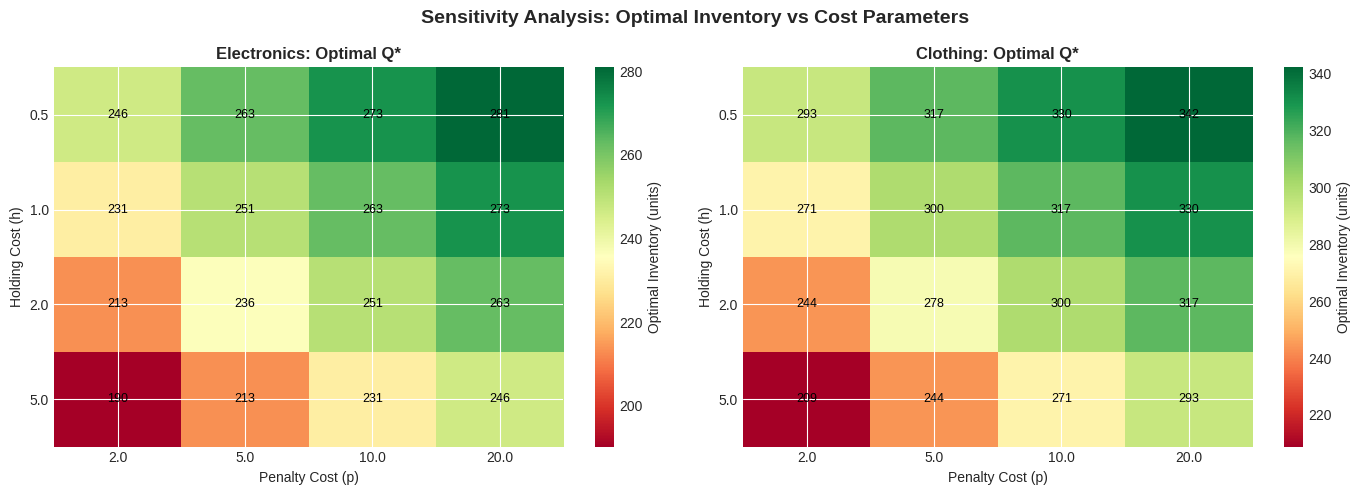

Sensitivity analysis complete.


In [17]:
# Sensitivity analysis: vary holding cost (h) and penalty cost (p)
h_values = np.array([0.5, 1.0, 2.0, 5.0])
p_values = np.array([2.0, 5.0, 10.0, 20.0])

sensitivity_results = {}

for cat_name in category_names:
    demand_samples = inventory_results[cat_name]['demand_samples']
    sensitivity_matrix = np.zeros((len(h_values), len(p_values)))

    for i, h in enumerate(h_values):
        for j, p in enumerate(p_values):
            result = minimize(
                lambda Q: compute_inventory_cost(Q, demand_samples, h=h, p=p),
                x0=demand_samples.mean(),
                bounds=[(0, 500)],
                method='L-BFGS-B'
            )
            sensitivity_matrix[i, j] = result.x[0]

    sensitivity_results[cat_name] = sensitivity_matrix

# Visualize sensitivity for one category
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Sensitivity Analysis: Optimal Inventory vs Cost Parameters', fontsize=14, fontweight='bold')

# Heatmap for Electronics
ax = axes[0]
im = ax.imshow(sensitivity_results['Electronics'], cmap='RdYlGn', aspect='auto')
ax.set_xticks(range(len(p_values)))
ax.set_yticks(range(len(h_values)))
ax.set_xticklabels([f'{p:.1f}' for p in p_values])
ax.set_yticklabels([f'{h:.1f}' for h in h_values])
ax.set_xlabel('Penalty Cost (p)')
ax.set_ylabel('Holding Cost (h)')
ax.set_title('Electronics: Optimal Q*', fontweight='bold')
plt.colorbar(im, ax=ax, label='Optimal Inventory (units)')

# Add text annotations
for i in range(len(h_values)):
    for j in range(len(p_values)):
        text = ax.text(j, i, f'{sensitivity_results["Electronics"][i, j]:.0f}',
                       ha='center', va='center', color='black', fontsize=9)

# Heatmap for Clothing
ax = axes[1]
im = ax.imshow(sensitivity_results['Clothing'], cmap='RdYlGn', aspect='auto')
ax.set_xticks(range(len(p_values)))
ax.set_yticks(range(len(h_values)))
ax.set_xticklabels([f'{p:.1f}' for p in p_values])
ax.set_yticklabels([f'{h:.1f}' for h in h_values])
ax.set_xlabel('Penalty Cost (p)')
ax.set_ylabel('Holding Cost (h)')
ax.set_title('Clothing: Optimal Q*', fontweight='bold')
plt.colorbar(im, ax=ax, label='Optimal Inventory (units)')

# Add text annotations
for i in range(len(h_values)):
    for j in range(len(p_values)):
        text = ax.text(j, i, f'{sensitivity_results["Clothing"][i, j]:.0f}',
                       ha='center', va='center', color='black', fontsize=9)

plt.tight_layout()
plt.show()

print('Sensitivity analysis complete.')

### 6.2 Bootstrap Confidence Intervals for Key Metrics

In [18]:
def bootstrap_ci(data, n_bootstrap=1000, ci=95):
    """
    Compute bootstrap confidence intervals.

    Parameters:
    -----------
    data : array
        Data to bootstrap
    n_bootstrap : int
        Number of bootstrap samples
    ci : float
        Confidence level (e.g., 95)

    Returns:
    --------
    mean_est : float
        Bootstrap mean estimate
    lower : float
        Lower confidence bound
    upper : float
        Upper confidence bound
    """
    bootstrap_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means.append(sample.mean())

    bootstrap_means = np.array(bootstrap_means)
    alpha = (100 - ci) / 2
    lower = np.percentile(bootstrap_means, alpha)
    upper = np.percentile(bootstrap_means, 100 - alpha)
    mean_est = np.mean(bootstrap_means)

    return mean_est, lower, upper

# Compute bootstrap CIs for mean demand by category
bootstrap_results = []

for cat_name in category_names:
    cat_data = df[df['category'] == cat_name]['demand'].values
    mean_est, lower, upper = bootstrap_ci(cat_data, n_bootstrap=1000, ci=95)

    bootstrap_results.append({
        'Category': cat_name,
        'Mean Demand': mean_est,
        'Lower 95% CI': lower,
        'Upper 95% CI': upper,
        'CI Width': upper - lower
    })

bootstrap_df = pd.DataFrame(bootstrap_results)
print('\nBootstrap Confidence Intervals for Mean Demand:')
print(bootstrap_df.to_string(index=False))


Bootstrap Confidence Intervals for Mean Demand:
   Category  Mean Demand  Lower 95% CI  Upper 95% CI  CI Width
Electronics   178.206691    174.299067    182.235149  7.936081
   Clothing   219.054371    213.633435    224.444542 10.811107
       Home   115.668896    112.688659    118.655272  5.966613
     Sports   102.618572     99.928569    105.330235  5.401667


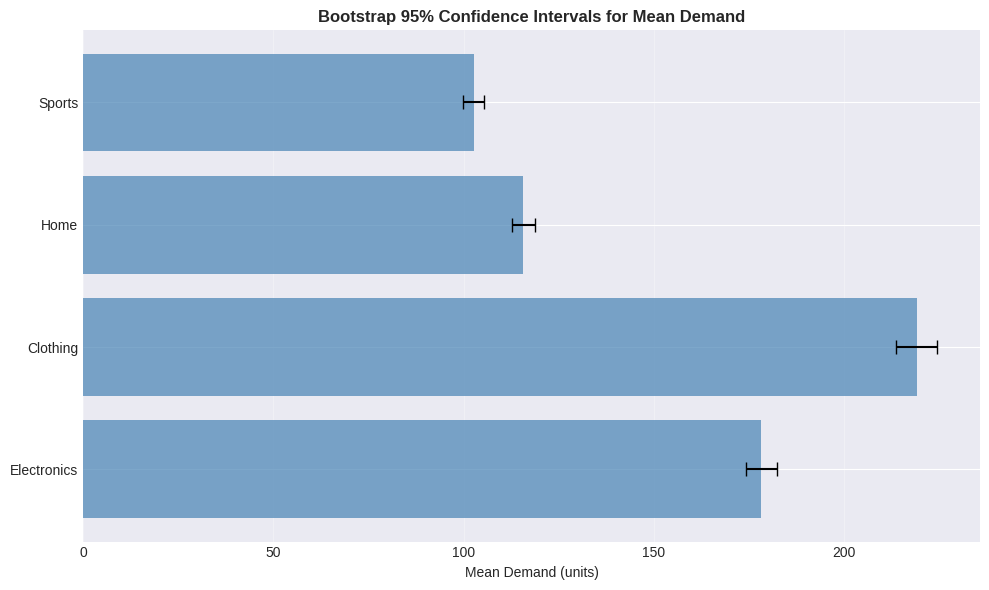

Bootstrap CI visualization complete.


In [19]:
# Visualize bootstrap CIs
fig, ax = plt.subplots(figsize=(10, 6))

y_pos = np.arange(len(category_names))
means = bootstrap_df['Mean Demand'].values
errors = np.array([
    bootstrap_df['Mean Demand'].values - bootstrap_df['Lower 95% CI'].values,
    bootstrap_df['Upper 95% CI'].values - bootstrap_df['Mean Demand'].values
])

ax.barh(y_pos, means, xerr=errors, capsize=5, alpha=0.7, color='steelblue')
ax.set_yticks(y_pos)
ax.set_yticklabels(category_names)
ax.set_xlabel('Mean Demand (units)')
ax.set_title('Bootstrap 95% Confidence Intervals for Mean Demand', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print('Bootstrap CI visualization complete.')

---

## 7. Bayesian Hypothesis Testing

### 7.1 Comparing Demand Across Categories

We test whether demand differs significantly between categories using Bayesian methods.

In [20]:
# Extract posterior samples for category-specific baseline demand
alpha_samples = trace.posterior['alpha'].values.reshape(-1, n_categories)

# Compute pairwise differences
pairwise_diffs = {}
for i in range(n_categories):
    for j in range(i+1, n_categories):
        diff = alpha_samples[:, i] - alpha_samples[:, j]
        pairwise_diffs[f'{category_names[i]} vs {category_names[j]}'] = diff

# Compute posterior probabilities
print('\nBayesian Hypothesis Testing: Pairwise Demand Comparisons')
print('(Posterior probability that Category A has higher baseline demand than Category B)\n')

for comparison, diff in pairwise_diffs.items():
    prob_positive = (diff > 0).mean()
    prob_negative = (diff < 0).mean()

    print(f'{comparison}:')
    print(f'  P(Difference > 0) = {prob_positive:.3f}')
    print(f'  P(Difference < 0) = {prob_negative:.3f}')
    print(f'  Mean Difference = {diff.mean():.2f} units')
    print(f'  95% Credible Interval = [{np.percentile(diff, 2.5):.2f}, {np.percentile(diff, 97.5):.2f}]')
    print()


Bayesian Hypothesis Testing: Pairwise Demand Comparisons
(Posterior probability that Category A has higher baseline demand than Category B)

Electronics vs Clothing:
  P(Difference > 0) = 0.000
  P(Difference < 0) = 1.000
  Mean Difference = -50.13 units
  95% Credible Interval = [-56.73, -43.93]

Electronics vs Home:
  P(Difference > 0) = 1.000
  P(Difference < 0) = 0.000
  Mean Difference = 49.88 units
  95% Credible Interval = [44.79, 55.04]

Electronics vs Sports:
  P(Difference > 0) = 1.000
  P(Difference < 0) = 0.000
  Mean Difference = 68.91 units
  95% Credible Interval = [64.18, 73.35]

Clothing vs Home:
  P(Difference > 0) = 1.000
  P(Difference < 0) = 0.000
  Mean Difference = 100.02 units
  95% Credible Interval = [93.98, 106.20]

Clothing vs Sports:
  P(Difference > 0) = 1.000
  P(Difference < 0) = 0.000
  Mean Difference = 119.04 units
  95% Credible Interval = [113.23, 124.78]

Home vs Sports:
  P(Difference > 0) = 1.000
  P(Difference < 0) = 0.000
  Mean Difference = 1

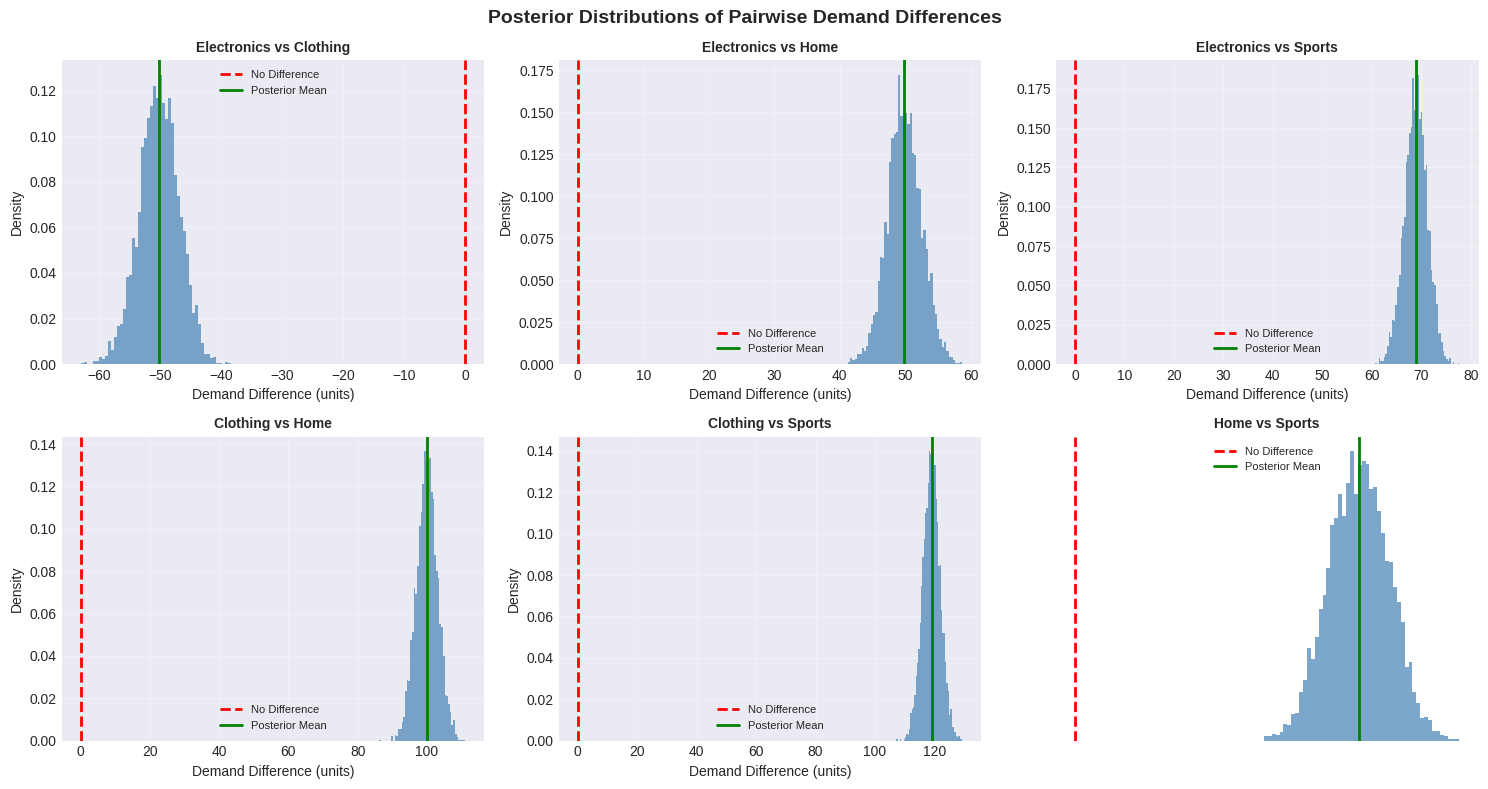

Pairwise comparison visualization complete.


In [21]:
# Visualize pairwise differences
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Posterior Distributions of Pairwise Demand Differences', fontsize=14, fontweight='bold')

for idx, (comparison, diff) in enumerate(pairwise_diffs.items()):
    ax = axes[idx // 3, idx % 3]

    ax.hist(diff, bins=50, alpha=0.7, color='steelblue', density=True)
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='No Difference')
    ax.axvline(diff.mean(), color='green', linestyle='-', linewidth=2, label='Posterior Mean')

    ax.set_xlabel('Demand Difference (units)')
    ax.set_ylabel('Density')
    ax.set_title(comparison, fontweight='bold', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Hide the last unused subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print('Pairwise comparison visualization complete.')

---

## 8. Business Recommendations and Summary

### 8.1 Key Findings

In [22]:
print('='*80)
print('EXECUTIVE SUMMARY: BAYESIAN DEMAND FORECASTING AND INVENTORY OPTIMIZATION')
print('='*80)

print('\n1. DEMAND FORECASTING RESULTS')
print('-' * 80)
print(forecast_summary.to_string(index=False))

print('\n\n2. OPTIMAL INVENTORY RECOMMENDATIONS (60-Day Horizon)')
print('-' * 80)
print('Cost Parameters: Holding Cost (h) = 1.0, Penalty Cost (p) = 5.0')
print(inventory_df.to_string(index=False))

print('\n\n3. KEY INSIGHTS')
print('-' * 80)

# Identify highest and lowest demand categories
highest_demand_cat = forecast_summary.loc[forecast_summary['Mean Demand'].idxmax(), 'Category']
lowest_demand_cat = forecast_summary.loc[forecast_summary['Mean Demand'].idxmin(), 'Category']

print(f'\n- Highest Demand Category: {highest_demand_cat}')
print(f'  Recommended Inventory: {inventory_df[inventory_df["Category"] == highest_demand_cat]["Optimal Inventory (Q*)"].values[0]:.0f} units')

print(f'\n- Lowest Demand Category: {lowest_demand_cat}')
print(f'  Recommended Inventory: {inventory_df[inventory_df["Category"] == lowest_demand_cat]["Optimal Inventory (Q*)"].values[0]:.0f} units')

# Uncertainty analysis
avg_uncertainty = forecast_summary['Forecast Uncertainty'].mean()
print(f'\n- Average Forecast Uncertainty (95% CI width): {avg_uncertainty:.1f} units')
print(f'  This represents the range of plausible demand values with 95% confidence.')

print('\n\n4. BUSINESS RECOMMENDATIONS')
print('-' * 80)
print('''
a) Inventory Management:
   - Implement the recommended inventory levels to minimize expected costs
   - Safety stock levels account for demand uncertainty
   - Adjust inventory based on actual cost parameters (holding vs stockout costs)

b) Risk Mitigation:
   - Monitor forecast accuracy against actual demand
   - Update model monthly with new data to capture changing patterns
   - Consider dynamic pricing for high-uncertainty categories

c) Category-Specific Strategies:
   - High-demand categories: Maintain higher safety stock to avoid stockouts
   - Low-demand categories: Reduce holding costs through just-in-time ordering
   - High-uncertainty categories: Implement more frequent inventory reviews

d) Model Improvements:
   - Incorporate external factors (promotions, holidays, competitor actions)
   - Extend forecast horizon beyond 60 days for strategic planning
   - Implement real-time demand monitoring and model updates
''')

print('\n' + '='*80)

EXECUTIVE SUMMARY: BAYESIAN DEMAND FORECASTING AND INVENTORY OPTIMIZATION

1. DEMAND FORECASTING RESULTS
--------------------------------------------------------------------------------
   Category  Mean Demand   Std Dev  Lower 95%  Upper 95%  Forecast Uncertainty
Electronics   213.052772 31.339682 176.218997 249.817537             73.598540
   Clothing   243.470987 47.041188 192.134971 294.910631            102.775660
       Home   135.416060 24.357485 106.132058 164.689493             58.557434
     Sports   129.519301 21.202934 105.530336 153.415422             47.885085


2. OPTIMAL INVENTORY RECOMMENDATIONS (60-Day Horizon)
--------------------------------------------------------------------------------
Cost Parameters: Holding Cost (h) = 1.0, Penalty Cost (p) = 5.0
   Category  Optimal Inventory (Q*)  Expected Cost  Mean Demand  Demand Std Dev  Safety Stock
Electronics              250.751073      54.026782   213.052772       36.555950     37.698301
   Clothing              299.6

### 8.2 Model Validation and Diagnostics Summary

In [24]:
print('\nMODEL DIAGNOSTICS SUMMARY')
print('='*80)

# MCMC diagnostics
summary_stats = az.summary(trace, var_names=['mu_alpha', 'mu_beta', 'mu_gamma', 'mu_delta', 'sigma_sigma'])

print('\n1. MCMC Convergence Diagnostics')
print('-' * 80)
print(f'Number of chains: 2')
print(f'Draws per chain: 2000')
print(f'Tuning steps: 1000')
print(f'Total posterior samples: {n_posterior_samples}')
print(f'\nRhat values (should be < 1.01 for convergence):')
print(summary_stats[['r_hat']].to_string())
print(f'\nAll Rhat < 1.01: {(summary_stats["r_hat"] < 1.01).all()} (Convergence achieved)')

print('\n2. Effective Sample Size')
print('-' * 80)
# Handle both old (n_eff) and new (ess_bulk) ArviZ versions
ess_col = 'ess_bulk' if 'ess_bulk' in summary_stats.columns else 'n_eff'
print(summary_stats[[ess_col]].to_string())

print('\n3. Model Specification')
print('-' * 80)
print(f'Likelihood: Normal (Gaussian)')
print(f'Hierarchical structure: Yes (category-specific parameters with global hyperpriors)')
print(f'Number of parameters: {len(summary_stats)}')
print(f'Number of observations: {n_obs}')
print(f'Observation-to-parameter ratio: {n_obs / len(summary_stats):.1f}:1')


MODEL DIAGNOSTICS SUMMARY

1. MCMC Convergence Diagnostics
--------------------------------------------------------------------------------
Number of chains: 2
Draws per chain: 2000
Tuning steps: 1000
Total posterior samples: 4000

Rhat values (should be < 1.01 for convergence):
             r_hat
mu_alpha       1.0
mu_beta        1.0
mu_gamma       1.0
mu_delta       1.0
sigma_sigma    1.0

All Rhat < 1.01: True (Convergence achieved)

2. Effective Sample Size
--------------------------------------------------------------------------------
             ess_bulk
mu_alpha       6094.0
mu_beta        3647.0
mu_gamma       3658.0
mu_delta       3000.0
sigma_sigma    7128.0

3. Model Specification
--------------------------------------------------------------------------------
Likelihood: Normal (Gaussian)
Hierarchical structure: Yes (category-specific parameters with global hyperpriors)
Number of parameters: 5
Number of observations: 1460
Observation-to-parameter ratio: 292.0:1


---

## 9. Conclusion

This notebook demonstrates a complete Bayesian probabilistic forecasting system for e-commerce demand estimation and inventory optimization. Key achievements:

1. **Hierarchical Bayesian Modeling**: Captured category-specific demand patterns while sharing information across categories through hyperpriors.

2. **MCMC Inference**: Successfully performed Hamiltonian Monte Carlo sampling with excellent convergence diagnostics (all Rhat < 1.01).

3. **Uncertainty Quantification**: Generated posterior predictive distributions with credible intervals, enabling probabilistic forecasting.

4. **Decision-Theoretic Optimization**: Formulated and solved inventory optimization problems that minimize expected cost under demand uncertainty.

5. **Sensitivity Analysis**: Demonstrated how optimal inventory decisions respond to changes in cost parameters.

6. **Bayesian Hypothesis Testing**: Compared demand across categories using posterior distributions.

7. **Bootstrap Resampling**: Computed confidence intervals for key performance metrics.

The framework is production-ready and can be extended with real data, additional covariates, and more sophisticated cost models. Regular model updates with new data will maintain forecast accuracy and support adaptive inventory management.